In [2]:
from auto_robot_design.motion_planning.dataset_generator import Dataset

dataset = Dataset("/var/home/yefim-work/Documents/auto-robotics-design/top_5")

In [3]:
import numpy as np

df = dataset.df
low_bnds = np.array(
    [value[0] for value in dataset.graph_manager.mutation_ranges.values()]
)[np.newaxis, :]
up_bnds = np.array(
    [value[1] for value in dataset.graph_manager.mutation_ranges.values()]
)[np.newaxis, :]
np.round(df.mean(0).values[: dataset.params_size], 4), np.round(
    df.std(0).values[: dataset.params_size], 4
)

(array([-0.1  ,  0.036, -0.2  , -0.   , -0.1  , -0.   ,  0.15 , -0.06 ,
        -0.   , -0.025, -0.13 , -0.06 ,  0.1  ]),
 array([0.0577, 0.0375, 0.0577, 0.1155, 0.2887, 0.1155, 0.2598, 0.0231,
        0.0577, 0.0433, 0.0693, 0.0231, 0.0289]))

In [4]:
low_bnds, up_bnds

(array([[-0.2  , -0.029, -0.3  , -0.2  , -0.6  , -0.2  , -0.3  , -0.1  ,
         -0.1  , -0.1  , -0.25 , -0.1  ,  0.05 ]]),
 array([[ 0.   ,  0.101, -0.1  ,  0.2  ,  0.4  ,  0.2  ,  0.6  , -0.02 ,
          0.1  ,  0.05 , -0.01 , -0.02 ,  0.15 ]]))

In [5]:
df.values[:, : dataset.params_size].max(0), df.values[:, : dataset.params_size].min(0)

(array([-0.   ,  0.101, -0.1  ,  0.2  ,  0.4  ,  0.2  ,  0.6  , -0.02 ,
         0.1  ,  0.05 , -0.01 , -0.02 ,  0.15 ]),
 array([-0.2  , -0.029, -0.3  , -0.2  , -0.6  , -0.2  , -0.3  , -0.1  ,
        -0.1  , -0.1  , -0.25 , -0.1  ,  0.05 ]))

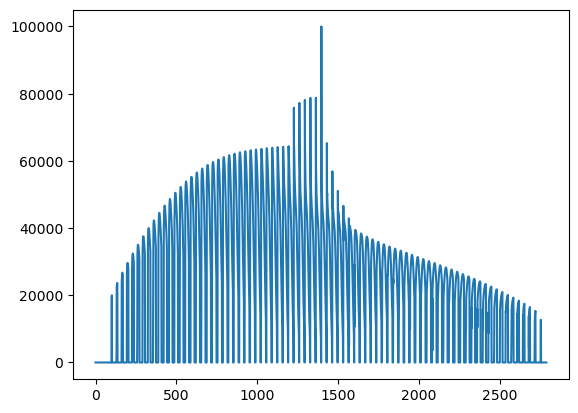

In [6]:
import matplotlib.pyplot as plt

dense_ws_point = np.sum(
    df.values[:, dataset.params_size : dataset.params_size + dataset.ws_grid_size],
    axis=0,
)
plt.plot(range(dataset.ws_grid_size), dense_ws_point)

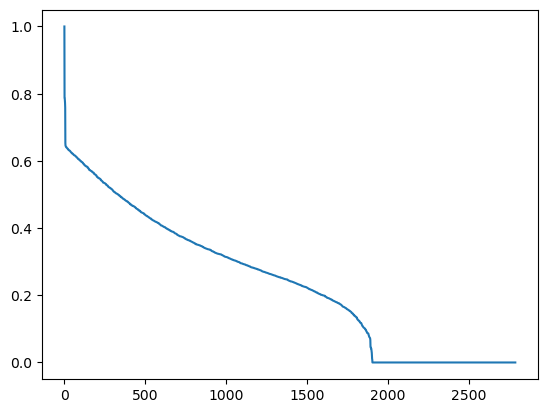

In [6]:
from matplotlib.patches import StepPatch

sorted_dense_points = sorted(dense_ws_point / df.shape[0], reverse=True)
plt.plot(range(dataset.ws_grid_size), sorted_dense_points)

In [7]:
upd_df = df.assign(
    total_ws=lambda x: np.sum(
        x.values[:, dataset.params_size : dataset.params_size + dataset.ws_grid_size],
        axis=1,
    )
)
sorted_df = upd_df.sort_values("total_ws", ascending=False)
best_index_ws_sample = sorted_df.head(1).index[0]
best_index_ws_sample

63966

In [8]:
from auto_robot_design.description.builder import (
    ParametrizedBuilder,
    URDFLinkCreater3DConstraints,
    jps_graph2pinocchio_robot_3d_constraints,
    MIT_CHEETAH_PARAMS_DICT,
)

thickness = MIT_CHEETAH_PARAMS_DICT["thickness"]
actuator = MIT_CHEETAH_PARAMS_DICT["actuator"]
density = MIT_CHEETAH_PARAMS_DICT["density"]
body_density = MIT_CHEETAH_PARAMS_DICT["body_density"]


builder = ParametrizedBuilder(
    URDFLinkCreater3DConstraints,
    density={"default": density, "G": body_density},
    thickness={"default": thickness, "EE": 0.033},
    actuator={"default": actuator},
    size_ground=np.array(MIT_CHEETAH_PARAMS_DICT["size_ground"]),
    offset_ground=MIT_CHEETAH_PARAMS_DICT["offset_ground_rl"],
)

dataset.builder = builder

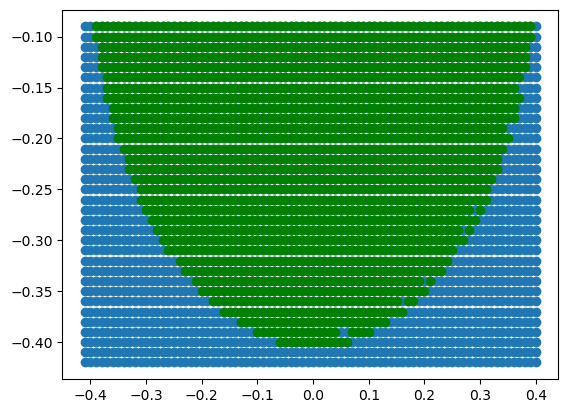

In [9]:
ws = dataset.get_workspace_by_indexes([best_index_ws_sample])[0]
reachable_pts = ws.reachable_points
pts = ws.points

plt.plot(reachable_pts[:, 0], reachable_pts[:, 1], "og")
plt.scatter(pts[:, 0], pts[:, 1])

In [10]:
from auto_robot_design.utils.meshcat_vizualizer.vizualizer import MeshcatVisualizer

viz = MeshcatVisualizer(
    model=ws.robot.model,
    collision_model=ws.robot.visual_model,
    visual_model=ws.robot.visual_model,
)
# viz.viewer = meshcat.Visualizer().open()
viz.viewer.jupyter_cell()
viz.viewer["/Background"].set_property("visible", False)
viz.viewer["/Grid"].set_property("visible", False)
viz.viewer["/Axes"].set_property("visible", False)
viz.viewer["/Cameras/default/rotated/<object>"].set_property("position", [0, 0, 0.5])
viz.clean()
viz.loadViewerModel()

viz.display(np.zeros(ws.robot.model.nq))

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


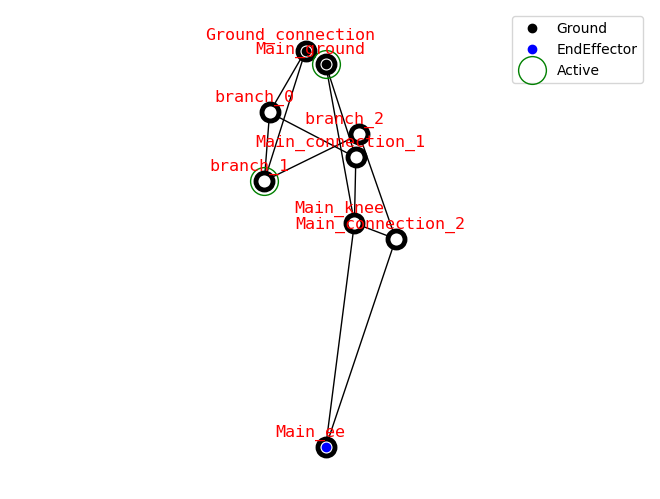

In [11]:
from auto_robot_design.description.utils import draw_joint_point

graph = dataset.get_graphs_by_indexes([best_index_ws_sample])[0]

draw_joint_point(graph)

In [12]:
from auto_robot_design.user_interface.check_in_ellips import (
    Ellipse,
    check_points_in_ellips,
)

center_ellps = np.array([0.05, -0.21])
ellipse = Ellipse(center_ellps, 0, np.array([0.1, 0.04]))
points_on_ellps = ellipse.get_points(0.1).T

reach_ws_points = ws.points
mask_ws_n_ellps = check_points_in_ellips(reach_ws_points, ellipse, 0.1)

In [14]:
design_indexes_include_ellps = dataset.get_all_design_indexes_cover_ellipse(ellipse)
design_indexes_include_ellps.size

15707

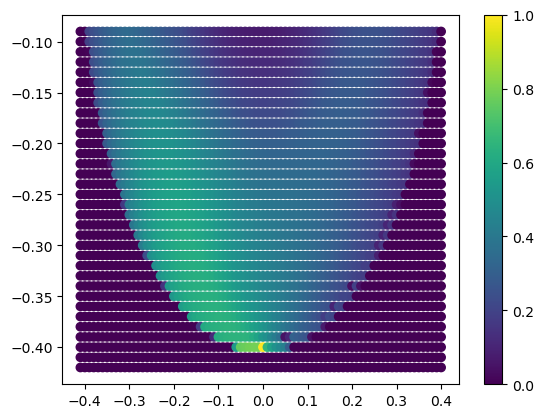

In [15]:
pts = dataset.workspace.points
plt.scatter(pts[:, 0], pts[:, 1], c=dense_ws_point / dataset.df.shape[0])
plt.colorbar()

In [16]:
from auto_robot_design.pinokla.default_traj import add_auxilary_points_to_trajectory


gm = dataset.graph_manager
traj = np.array(
    add_auxilary_points_to_trajectory(([center_ellps[0]], [center_ellps[1]]))
).T
ws.check_points_in_ws(traj)

True

In [17]:
from auto_robot_design.motion_planning.trajectory_ik_manager import TrajectoryIKManager
from auto_robot_design.vizualization.meshcat_utils import create_meshcat_vizualizer

fixed_robot = ws.robot
traj_6d = fixed_robot.motion_space.get_6d_traj(traj)
ik_manager = TrajectoryIKManager()
ik_manager.register_model(fixed_robot.model, fixed_robot.constraint_models)
ik_manager.set_solver("Closed_Loop_PI")
poses, q_fixed, constraint_errors, reach_array = ik_manager.follow_trajectory(traj_6d)

In [18]:
sorted_df["acc_cap"] = np.zeros(sorted_df.shape[0])
sorted_df["heavy_lift"] = np.zeros(sorted_df.shape[0])
sorted_df["total_criteria"] = np.zeros(sorted_df.shape[0])

In [19]:
from auto_robot_design.pinokla.calc_criterion import (
    ActuatedMass,
    EffectiveInertiaCompute,
    MovmentSurface,
    NeutralPoseMass,
    ManipJacobian,
)
from auto_robot_design.pinokla.criterion_agregator import CriteriaAggregator
from auto_robot_design.optimization.rewards.reward_base import RewardManager
from auto_robot_design.optimization.rewards.jacobian_and_inertia_rewards import (
    HeavyLiftingReward,
    MinAccelerationCapability,
)

import time

from concurrent.futures import ProcessPoolExecutor

dict_trajectory_criteria = {
    "MASS": NeutralPoseMass(),
}
# criteria calculated for each point on the trajectory
dict_point_criteria = {
    "Effective_Inertia": EffectiveInertiaCompute(),
    "Actuated_Mass": ActuatedMass(),
    "Manip_Jacobian": ManipJacobian(MovmentSurface.XZ),
}
# special object that calculates the criteria for a robot and a trajectory
crag = CriteriaAggregator(dict_point_criteria, dict_trajectory_criteria)

# set the rewards and weights for the optimization task
acceleration_capability = MinAccelerationCapability(
    manipulability_key="Manip_Jacobian",
    trajectory_key="traj_6d",
    error_key="error",
    actuated_mass_key="Actuated_Mass",
)

heavy_lifting = HeavyLiftingReward(
    manipulability_key="Manip_Jacobian",
    trajectory_key="traj_6d",
    error_key="error",
    mass_key="MASS",
)


reward_manager = RewardManager(crag=crag)
reward_manager.add_trajectory(traj_6d, 0)

reward_manager.add_reward(acceleration_capability, 0, 1)
reward_manager.add_reward(heavy_lifting, 0, 1)
total_time = 0


def cacl_criteria(id_design):
    start = time.perf_counter()
    des = sorted_df.loc[id_design]
    jp_pos = des.values[: dataset.params_size].round(4)
    graph = gm.get_graph(jp_pos)
    fixed_robot, free_robot = jps_graph2pinocchio_robot_3d_constraints(graph, builder)
    reward_manager.precalculated_trajectories = None
    __, partial_rewards, vector_rewards = reward_manager.calculate_total(
        fixed_robot, free_robot, actuator
    )
    end = time.perf_counter()
    sorted_df.at[id_design, "acc_cap"] = vector_rewards[0]
    sorted_df.at[id_design, "heavy_lift"] = vector_rewards[1]
    sorted_df.at[id_design, "total_criteria"] = np.sum(partial_rewards)
    single_time = end - start
    print(single_time)

    return id_design, partial_rewards


for id_design in sorted_df.head(2000).index:
    start = time.perf_counter()
    des = sorted_df.loc[id_design]
    jp_pos = des.values[: dataset.params_size].round(4)
    graph = gm.get_graph(jp_pos)
    fixed_robot, free_robot = jps_graph2pinocchio_robot_3d_constraints(graph, builder)
    reward_manager.precalculated_trajectories = None
    __, partial_rewards, vector_rewards = reward_manager.calculate_total(
        fixed_robot, free_robot, actuator
    )
    end = time.perf_counter()
    sorted_df.at[id_design, "acc_cap"] = vector_rewards[0]
    sorted_df.at[id_design, "heavy_lift"] = vector_rewards[1]
    sorted_df.at[id_design, "total_criteria"] = np.sum(partial_rewards)
    single_time = end - start
    total_time += single_time
    print("time: ", np.round(single_time, 4))
print(total_time)

time:  0.1653
time:  0.1573
time:  0.1589
time:  0.156
time:  0.1613
time:  0.1567
time:  0.17
time:  0.1593
time:  0.163
time:  0.1592
time:  0.1602
time:  0.1589
time:  0.1587
time:  0.1594
time:  0.1651
time:  0.1584
time:  0.1614
time:  0.1583
time:  0.1551
time:  0.16
time:  0.1617
time:  0.1542
time:  0.1599
time:  0.1555
time:  0.1626
time:  0.1551
time:  0.163
time:  0.1699
time:  0.1719
time:  0.1688
time:  0.18
time:  0.1786
time:  0.177
time:  0.254
time:  0.1777
time:  0.169
time:  0.1755
time:  0.1759
time:  0.1807
time:  0.1921
time:  0.1629
time:  0.1735
time:  0.1738
time:  0.1716
time:  0.1866
time:  0.1663
time:  0.1666
time:  0.1632
time:  0.1608
time:  0.1671
time:  0.1694
time:  0.1958
time:  0.1676
time:  0.1753
time:  0.1915
time:  0.1754
time:  0.1808
time:  0.1777
time:  0.1546
time:  0.1672
time:  0.1569
time:  0.1665
time:  0.16
time:  0.1637
time:  0.1633
time:  0.173
time:  0.1573
time:  0.1658
time:  0.1648
time:  0.161
time:  0.1621
time:  0.1634
time:  0

/var/home/yefim-work/Documents/auto-robotics-design/auto_robot_design/description/builder.py:1242: UserWarning: Gimbal lock detected. Setting third angle to zero since it is not possible to uniquely determine all angles.
  return super().create_kinematic_graph(kinematic_graph, name)


time:  0.169
time:  0.1666
time:  0.1789
time:  0.1658
time:  0.1724
time:  0.1559
time:  0.1769
time:  0.1667
time:  0.1691
time:  0.1726
time:  0.1645
time:  0.1587
time:  0.178
time:  0.1729
time:  0.1792
time:  0.1587
time:  0.1621
time:  0.161
time:  0.1718
time:  0.1591
time:  0.1668
time:  0.1618
time:  0.1618
time:  0.1659
time:  0.1686
time:  0.1633
time:  0.1659
time:  0.1673
time:  0.1671
time:  0.1768
time:  0.174
time:  0.1584
time:  0.1594
time:  0.1594
time:  0.1621
time:  0.1564
time:  0.1654
time:  0.1538
time:  0.1586
time:  0.16
time:  0.1935
time:  0.1563
time:  0.1621
time:  0.1539
time:  0.1607
time:  0.158
time:  0.163
time:  0.1621
time:  0.1672
time:  0.168
time:  0.1682
time:  0.159
time:  0.1644
time:  0.1571
time:  0.1612
time:  0.1633
time:  0.1608
time:  0.1576
time:  0.1611
time:  0.1595
time:  0.1612
time:  0.172
time:  0.1751
time:  0.2576
time:  0.1652
time:  0.1644
time:  0.1704
time:  0.163
time:  0.1557
time:  0.1778
time:  0.1605
time:  0.1644
time

/var/home/yefim-work/Documents/auto-robotics-design/auto_robot_design/description/builder.py:1165: UserWarning: Gimbal lock detected. Setting third angle to zero since it is not possible to uniquely determine all angles.
  info_joint = self.creater.create_joint(joint)


time:  0.1696
time:  0.1614
time:  0.1863
time:  0.1612
time:  0.1656
time:  0.1573
time:  0.1694
time:  0.1568
time:  0.1675
time:  0.1589
time:  0.1612
time:  0.1641
time:  0.1641
time:  0.1619
time:  0.1667
time:  0.1649
time:  0.1661
time:  0.1796
time:  0.1753
time:  0.1625
time:  0.1754
time:  0.1663
time:  0.1788
time:  0.1604
time:  0.1632
time:  0.2742
time:  0.1679
time:  0.1703
time:  0.165
time:  0.1741
time:  0.1601
time:  0.1672
time:  0.1617
time:  0.1754
time:  0.1652
time:  0.1645
time:  0.1651
time:  0.1645
time:  0.161
time:  0.1661
time:  0.1719
time:  0.1667
time:  0.1588
time:  0.1678
time:  0.1638
time:  0.1656
time:  0.1636
time:  0.1665
time:  0.1625
time:  0.1674
time:  0.1602
time:  0.1769
time:  0.1668
time:  0.1711
time:  0.1615
time:  0.1705
time:  0.1669
time:  0.1631
time:  0.1666
time:  0.1672
time:  0.1578
time:  0.1648
time:  0.1666
time:  0.1661
time:  0.1642
time:  0.1617
time:  0.1661
time:  0.1717
time:  0.1626
time:  0.1679
time:  0.159
time:  0.

In [24]:
sorted_df.head(2000).values[:, : dataset.params_size].max(0), sorted_df.head(
    2000
).values[:, : dataset.params_size].min(0)

(array([-0.   ,  0.101, -0.132,  0.2  ,  0.4  ,  0.2  ,  0.6  , -0.02 ,
         0.1  ,  0.05 , -0.01 , -0.02 ,  0.15 ]),
 array([-0.2  , -0.029, -0.245, -0.2  , -0.6  , -0.2  , -0.299, -0.1  ,
        -0.1  , -0.1  , -0.25 , -0.1  ,  0.05 ]))

In [25]:
sorted_df.head(2000).values[:, : dataset.params_size].mean(0).round(3), sorted_df.head(
    2000
).values[:, : dataset.params_size].std(0).round(3)

(array([-0.051,  0.033, -0.184, -0.005, -0.199, -0.031,  0.294, -0.073,
        -0.002, -0.02 , -0.149, -0.062,  0.111]),
 array([0.045, 0.036, 0.029, 0.115, 0.253, 0.107, 0.254, 0.02 , 0.051,
        0.046, 0.065, 0.024, 0.027]))

In [26]:
(up_bnds + low_bnds) / 2, up_bnds - low_bnds

(array([[-0.1  ,  0.036, -0.2  ,  0.   , -0.1  ,  0.   ,  0.15 , -0.06 ,
          0.   , -0.025, -0.13 , -0.06 ,  0.1  ]]),
 array([[0.2 , 0.13, 0.2 , 0.4 , 1.  , 0.4 , 0.9 , 0.08, 0.2 , 0.15, 0.24,
         0.08, 0.1 ]]))

In [27]:
np.round(gm.generate_central_from_mutation_range(), 3) - sorted_df.head(2000).values[
    :, : dataset.params_size
].mean(0).round(3)

array([-0.049,  0.003, -0.016,  0.005,  0.099,  0.031, -0.144,  0.013,
        0.002, -0.005,  0.019,  0.002, -0.011])

In [29]:
all_params_design = sorted_df.values[:, : dataset.params_size]
top_2k_params_design = sorted_df.head(2000).values[:, : dataset.params_size]
top_1k_params_design = sorted_df.head(1000).values[:, : dataset.params_size]
top_100_params_design = sorted_df.head(100).values[:, : dataset.params_size]
best_design_params = dataset.df.loc[best_index_ws_sample].values[: dataset.params_size]
acc_cap = sorted_df.head(2000)["acc_cap"].values
heavy_lift = sorted_df.head(2000)["heavy_lift"].values
total_criteria = sorted_df.head(2000)["total_criteria"].values

0.0

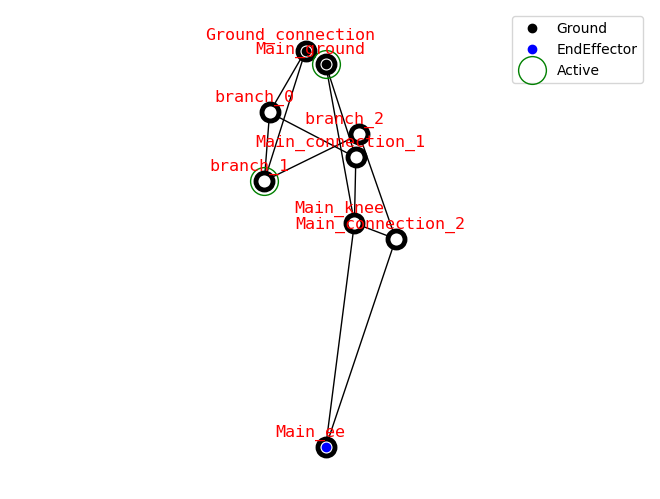

In [41]:
graph = dataset.get_graphs_by_indexes([best_index_ws_sample])[0]

draw_joint_point(graph)

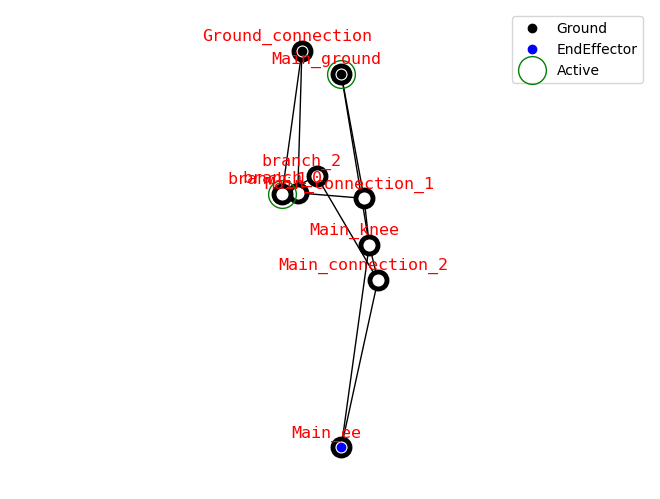

In [42]:
graph = gm.get_graph(
    sorted_df.head(100).values[:, : dataset.params_size].mean(0).round(4)
)
draw_joint_point(graph)

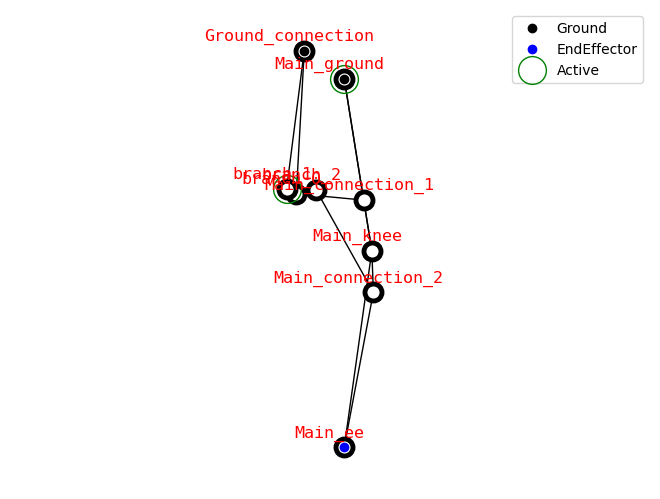

In [80]:
graph = gm.get_graph(
    sorted_df.head(1000).values[:, : dataset.params_size].mean(0).round(4)
)
draw_joint_point(graph)

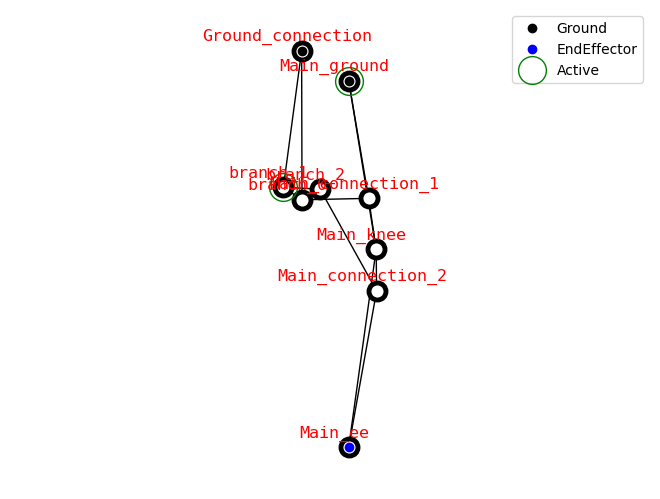

In [79]:
graph = gm.get_graph(
    sorted_df.head(2000).values[:, : dataset.params_size].mean(0).round(4)
)
draw_joint_point(graph)

In [30]:
low_bnds = low_bnds.squeeze()
up_bnds = up_bnds.squeeze()

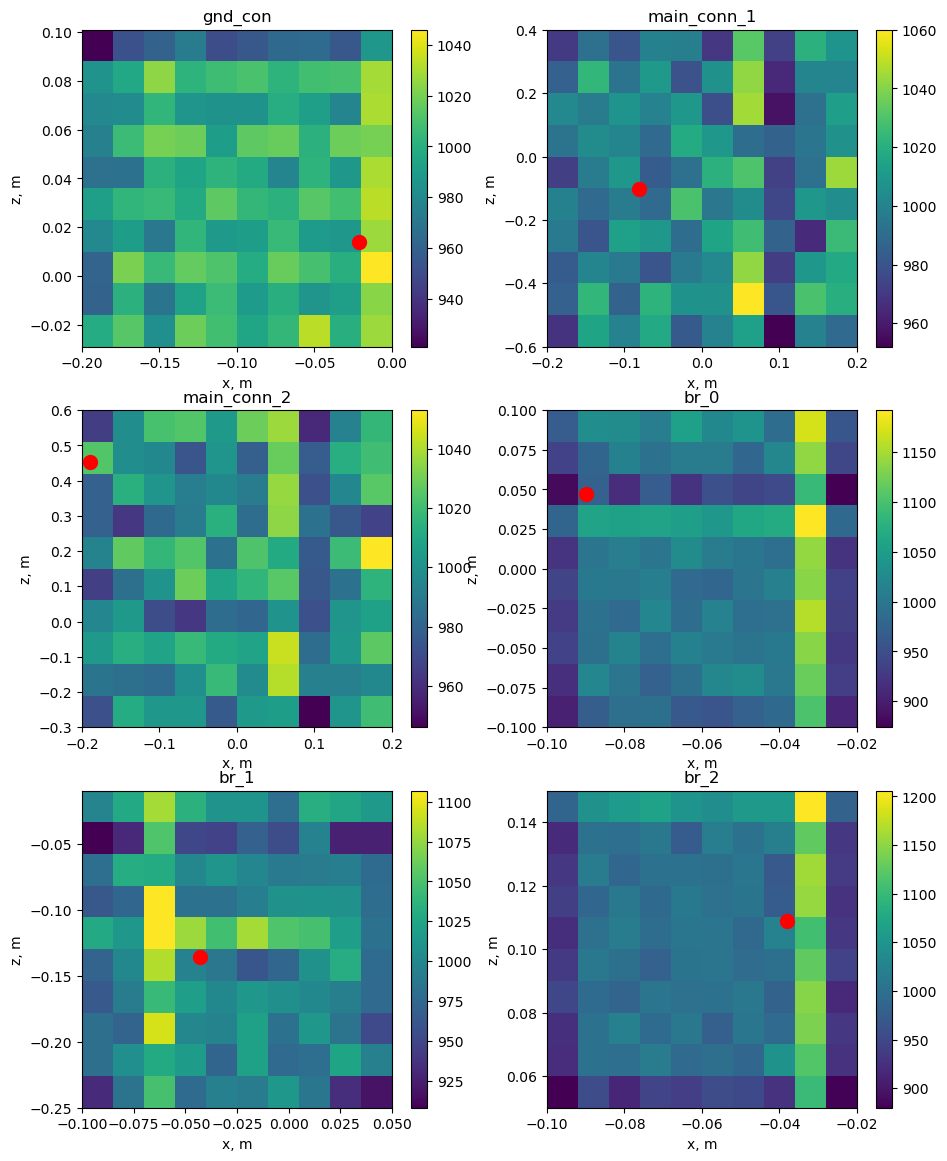

In [70]:
from matplotlib import colors

titles = ["gnd_con", "main_conn_1", "main_conn_2", "br_0", "br_1", "br_2"]
indexes = [[0, 1], [3, 4], [5, 6], [7, 8], [9, 10], [11, 12]]
fig, axs = plt.subplots(3, 2, figsize=(11, 14))

pcms = []
cmap = plt.colormaps["viridis"]
for ax, title, ind in zip(axs.flatten(), titles, indexes):
    pcms.append(
        ax.hist2d(
            all_params_design[:, ind[0]],
            all_params_design[:, ind[1]],
            bins=[10, 10],
            range=[
                [low_bnds[ind[0]], up_bnds[ind[0]]],
                [low_bnds[ind[1]], up_bnds[ind[1]]],
            ],
        )
    )
    norm = colors.Normalize(vmin=pcms[-1][0].min(), vmax=pcms[-1][0].max())
    fig.colorbar(plt.cm.ScalarMappable(norm, cmap=cmap), ax=ax)
    ax.plot(
        best_design_params[ind[0]], best_design_params[ind[1]], "ro", markeredgewidth=5
    )
    ax.set_title(title)
    ax.set_xlabel("x, m")
    ax.set_ylabel("z, m")

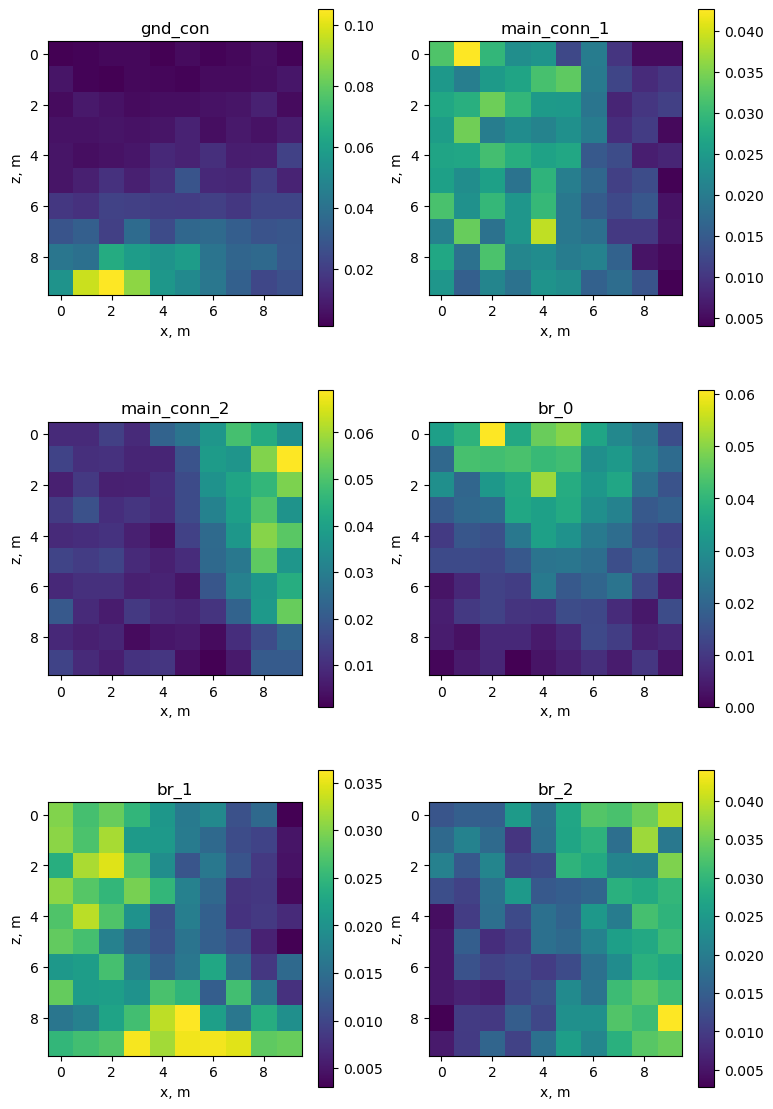

In [98]:
from scipy.stats import binned_statistic_2d

titles = ["gnd_con", "main_conn_1", "main_conn_2", "br_0", "br_1", "br_2"]
indexes = [[0, 1], [3, 4], [5, 6], [7, 8], [9, 10], [11, 12]]
fig, axs = plt.subplots(3, 2, figsize=(9, 14))
cmap = plt.colormaps["viridis"]
for pcm, ax, title, ind in zip(pcms, axs.flatten(), titles, indexes):
    hist = binned_statistic_2d(
        top_2k_params_design[:, ind[0]],
        top_2k_params_design[:, ind[1]],
        None,
        "count",
        bins=[10, 10],
        range=[
            [low_bnds[ind[0]], up_bnds[ind[0]]],
            [low_bnds[ind[1]], up_bnds[ind[1]]],
        ],
    )
    mtrx = hist[0] / pcm[0]
    # pcm = ax.hist2d(top_2k_params_design[:,ind[0]], top_2k_params_design[:,ind[1]], bins=[10,10], range=[[low_bnds[ind[0]], up_bnds[ind[0]]], [low_bnds[ind[1]], up_bnds[ind[1]]]])
    # ax.scatter(top_2k_params_design[:,ind[0]], top_2k_params_design[:,ind[1]], c=cmap(acc_cap), s=15, alpha=0.5)
    norm = colors.Normalize(vmin=mtrx.min(), vmax=mtrx.max())
    ax.imshow(mtrx, norm=norm)
    fig.colorbar(plt.cm.ScalarMappable(norm, cmap=cmap), ax=ax)
    # ax.set_xlim(low_bnds[ind[0]], up_bnds[ind[0]])
    # ax.set_ylim(low_bnds[ind[1]], up_bnds[ind[1]])
    # ax.plot(best_design_params[ind[0]],best_design_params[ind[1]], "ro", markeredgewidth=5)
    ax.set_title(title)
    ax.set_xlabel("x, m")
    ax.set_ylabel("z, m")

# plt.hist2d(top_2k_params_design[:,0], top_2k_params_design[:,1], bins=[40, 40])

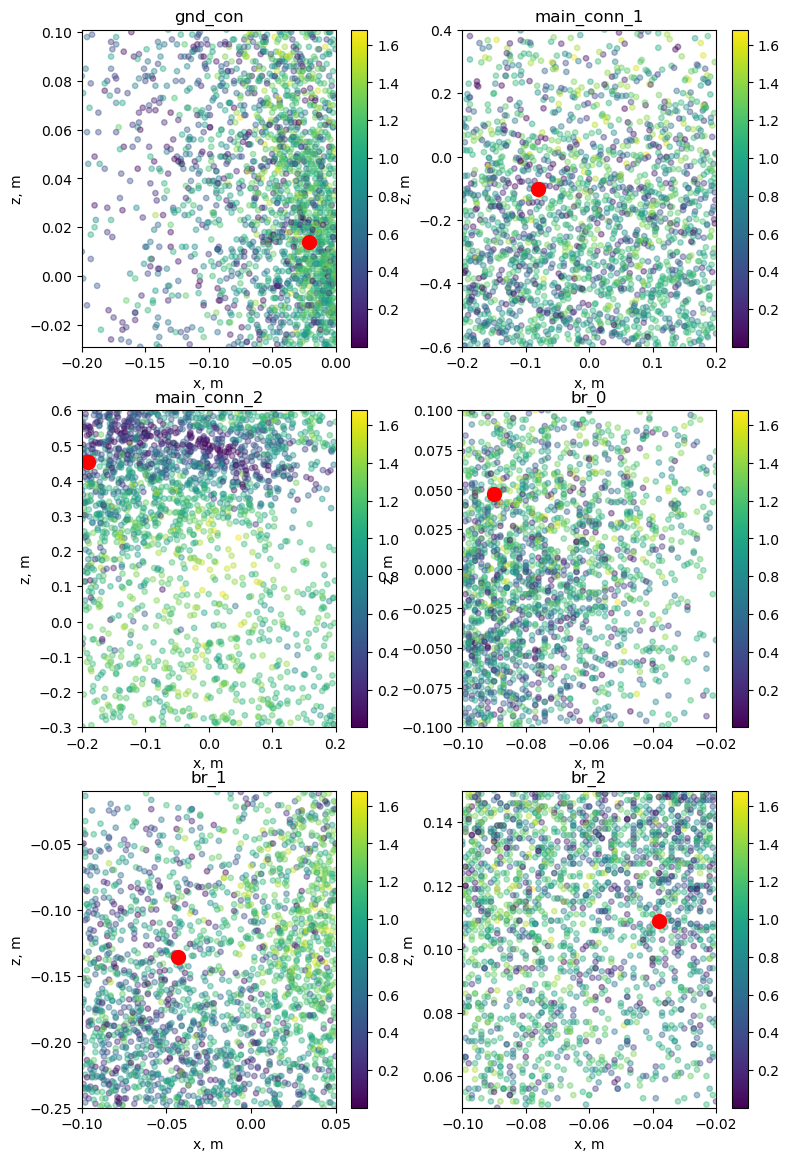

In [99]:
titles = ["gnd_con", "main_conn_1", "main_conn_2", "br_0", "br_1", "br_2"]
indexes = [[0, 1], [3, 4], [5, 6], [7, 8], [9, 10], [11, 12]]
fig, axs = plt.subplots(3, 2, figsize=(9, 14))

for ax, title, ind in zip(axs.flatten(), titles, indexes):
    ax.scatter(
        top_2k_params_design[:, ind[0]],
        top_2k_params_design[:, ind[1]],
        c=acc_cap,
        s=15,
        alpha=0.4,
    )
    ax.set_xlim(low_bnds[ind[0]], up_bnds[ind[0]])
    ax.set_ylim(low_bnds[ind[1]], up_bnds[ind[1]])
    norm = colors.Normalize(vmin=acc_cap.min(), vmax=acc_cap.max())
    fig.colorbar(plt.cm.ScalarMappable(norm, cmap=cmap), ax=ax)
    ax.plot(
        best_design_params[ind[0]], best_design_params[ind[1]], "ro", markeredgewidth=5
    )
    ax.set_title(title)
    ax.set_xlabel("x, m")
    ax.set_ylabel("z, m")

In [87]:
ind_hl_less_10 = np.argwhere(heavy_lift <= 10)

array([[   0],
       [   1],
       [   2],
       ...,
       [1997],
       [1998],
       [1999]])

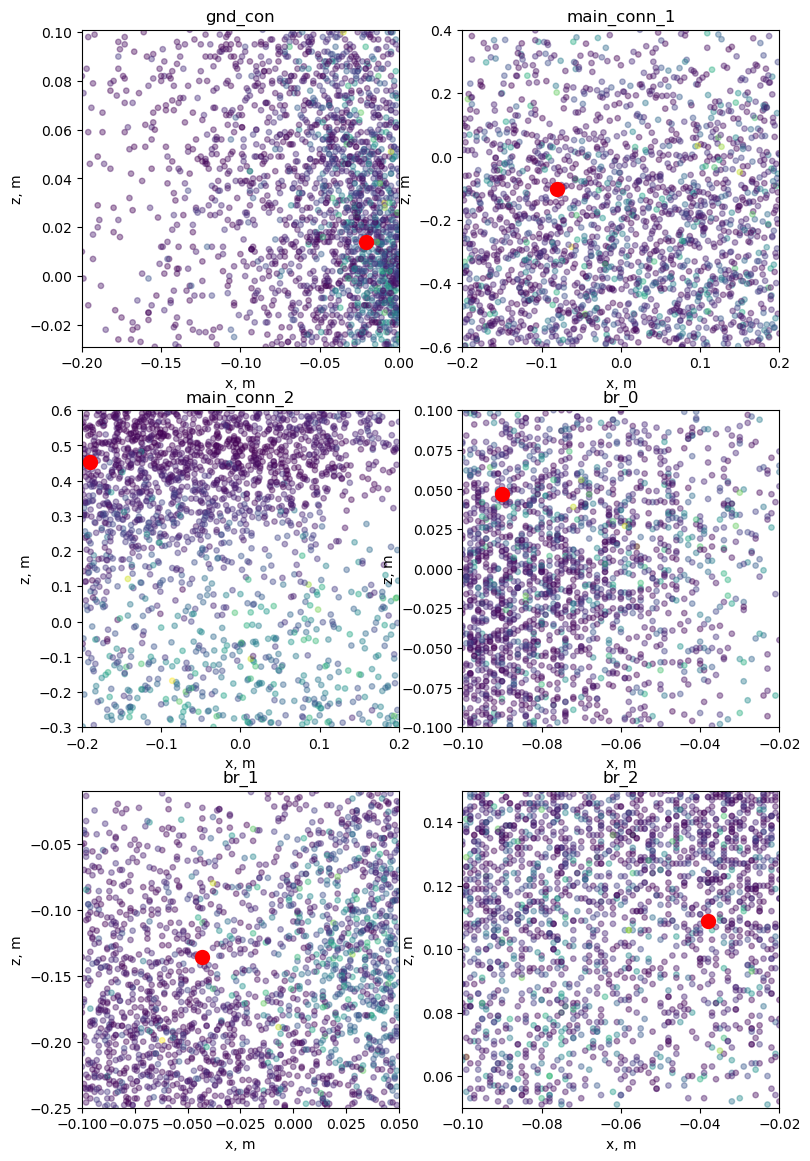

In [89]:
titles = ["gnd_con", "main_conn_1", "main_conn_2", "br_0", "br_1", "br_2"]
indexes = [[0, 1], [3, 4], [5, 6], [7, 8], [9, 10], [11, 12]]
fig, axs = plt.subplots(3, 2, figsize=(9, 14))

for ax, title, ind in zip(axs.flatten(), titles, indexes):
    ax.scatter(
        top_2k_params_design[ind_hl_less_10, ind[0]],
        top_2k_params_design[ind_hl_less_10, ind[1]],
        c=heavy_lift[ind_hl_less_10],
        s=15,
        alpha=0.4,
    )
    ax.set_xlim(low_bnds[ind[0]], up_bnds[ind[0]])
    ax.set_ylim(low_bnds[ind[1]], up_bnds[ind[1]])
    ax.plot(
        best_design_params[ind[0]], best_design_params[ind[1]], "ro", markeredgewidth=5
    )
    ax.set_title(title)
    ax.set_xlabel("x, m")
    ax.set_ylabel("z, m")

(array([13., 19., 17., 34., 34., 25., 32., 46., 47., 56., 56., 31., 41.,
        69., 66., 55., 63., 44., 68., 69., 71., 54., 49., 62., 65., 81.,
        64., 60., 52., 63., 51., 55., 62., 67., 38., 56., 50., 51., 41.,
        23.]),
 array([-0.245   , -0.242175, -0.23935 , -0.236525, -0.2337  , -0.230875,
        -0.22805 , -0.225225, -0.2224  , -0.219575, -0.21675 , -0.213925,
        -0.2111  , -0.208275, -0.20545 , -0.202625, -0.1998  , -0.196975,
        -0.19415 , -0.191325, -0.1885  , -0.185675, -0.18285 , -0.180025,
        -0.1772  , -0.174375, -0.17155 , -0.168725, -0.1659  , -0.163075,
        -0.16025 , -0.157425, -0.1546  , -0.151775, -0.14895 , -0.146125,
        -0.1433  , -0.140475, -0.13765 , -0.134825, -0.132   ]),
 <BarContainer object of 40 artists>)

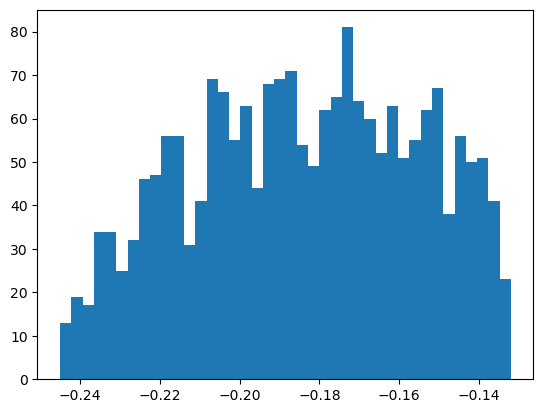

In [59]:
plt.hist(top_2k_params_design[:, 2], bins=40)

(array([[2., 2., 0., ..., 0., 0., 0.],
        [3., 4., 0., ..., 0., 0., 1.],
        [1., 0., 3., ..., 0., 1., 0.],
        ...,
        [3., 2., 1., ..., 0., 1., 0.],
        [0., 3., 3., ..., 0., 0., 1.],
        [0., 1., 3., ..., 0., 0., 0.]]),
 array([-0.2 , -0.19, -0.18, -0.17, -0.16, -0.15, -0.14, -0.13, -0.12,
        -0.11, -0.1 , -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03,
        -0.02, -0.01,  0.  ,  0.01,  0.02,  0.03,  0.04,  0.05,  0.06,
         0.07,  0.08,  0.09,  0.1 ,  0.11,  0.12,  0.13,  0.14,  0.15,
         0.16,  0.17,  0.18,  0.19,  0.2 ]),
 array([-6.00000000e-01, -5.75000000e-01, -5.50000000e-01, -5.25000000e-01,
        -5.00000000e-01, -4.75000000e-01, -4.50000000e-01, -4.25000000e-01,
        -4.00000000e-01, -3.75000000e-01, -3.50000000e-01, -3.25000000e-01,
        -3.00000000e-01, -2.75000000e-01, -2.50000000e-01, -2.25000000e-01,
        -2.00000000e-01, -1.75000000e-01, -1.50000000e-01, -1.25000000e-01,
        -1.00000000e-01, -7.50000000e-02, 

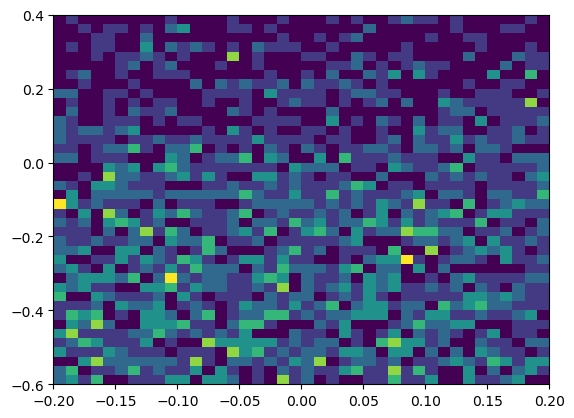

In [60]:
plt.hist2d(top_2k_params_design[:, 3], top_2k_params_design[:, 4], bins=[40, 40])

(array([[1., 0., 0., ..., 3., 2., 2.],
        [1., 0., 0., ..., 4., 1., 1.],
        [0., 0., 0., ..., 1., 6., 6.],
        ...,
        [0., 1., 2., ..., 1., 3., 2.],
        [2., 1., 0., ..., 0., 0., 0.],
        [3., 3., 1., ..., 0., 2., 0.]]),
 array([-0.2 , -0.19, -0.18, -0.17, -0.16, -0.15, -0.14, -0.13, -0.12,
        -0.11, -0.1 , -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03,
        -0.02, -0.01,  0.  ,  0.01,  0.02,  0.03,  0.04,  0.05,  0.06,
         0.07,  0.08,  0.09,  0.1 ,  0.11,  0.12,  0.13,  0.14,  0.15,
         0.16,  0.17,  0.18,  0.19,  0.2 ]),
 array([-0.299   , -0.276525, -0.25405 , -0.231575, -0.2091  , -0.186625,
        -0.16415 , -0.141675, -0.1192  , -0.096725, -0.07425 , -0.051775,
        -0.0293  , -0.006825,  0.01565 ,  0.038125,  0.0606  ,  0.083075,
         0.10555 ,  0.128025,  0.1505  ,  0.172975,  0.19545 ,  0.217925,
         0.2404  ,  0.262875,  0.28535 ,  0.307825,  0.3303  ,  0.352775,
         0.37525 ,  0.397725,  0.4202  ,  0.442675, 

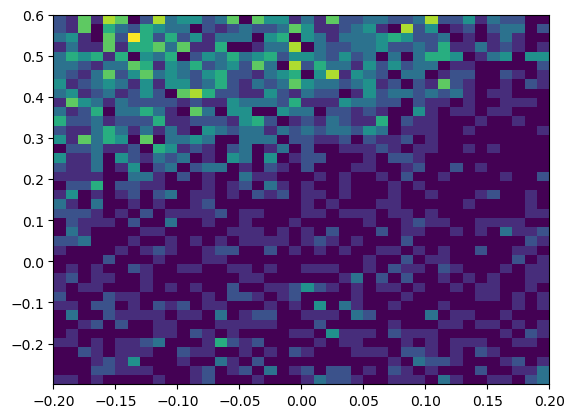

In [61]:
plt.hist2d(top_2k_params_design[:, 5], top_2k_params_design[:, 6], bins=[40, 40])